In [1]:
# Импорт библиотек
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import torchvision as tv
import time
from torch import nn

In [2]:
# Число бачей
bs = 256

In [3]:
# Загружаем данные
train_dataset = tv.datasets.FashionMNIST('.', train = True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=bs)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=bs)

In [4]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

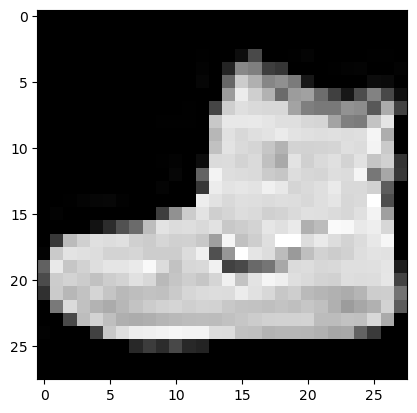

In [5]:
# Пример изображения
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [6]:
# Число классов - 10
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Выбираем девайс, который доступен
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
# У меня доступен cpu
dev

device(type='cpu')

In [9]:
# Создаем модель
# Оставляем арихитектуру модели, представленную на лекции 
# + я попробовала добавить слой батч-нормализации, потому что он улучшал аналогичную модель в предыдущем задании
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [10]:
# Отправляем модель на dev
model = model.to(dev)

In [11]:
# Определение функции
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [12]:
# Точность
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [14]:
# Обучение
lr, num_epochs = 0.001, 12
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)
# точность на тесте составила 89,6%

epoch 1, loss 0.2111, train acc 0.923, test acc 0.893, time 12.2 sec
epoch 2, loss 0.2054, train acc 0.925, test acc 0.895, time 11.2 sec
epoch 3, loss 0.1995, train acc 0.928, test acc 0.896, time 11.0 sec
epoch 4, loss 0.1938, train acc 0.929, test acc 0.896, time 13.8 sec
epoch 5, loss 0.1894, train acc 0.931, test acc 0.896, time 14.7 sec
epoch 6, loss 0.1847, train acc 0.933, test acc 0.895, time 12.1 sec
epoch 7, loss 0.1806, train acc 0.934, test acc 0.896, time 11.1 sec
epoch 8, loss 0.1761, train acc 0.936, test acc 0.896, time 15.4 sec
epoch 9, loss 0.1719, train acc 0.938, test acc 0.897, time 14.2 sec
epoch 10, loss 0.1686, train acc 0.939, test acc 0.898, time 11.2 sec
epoch 11, loss 0.1647, train acc 0.940, test acc 0.895, time 10.9 sec
epoch 12, loss 0.1609, train acc 0.943, test acc 0.896, time 11.0 sec
